In [1]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocessor import *

2024-07-03 20:34:22.109331: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 20:34:22.326654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 20:34:22.326690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 20:34:22.359506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 20:34:22.435517: I tensorflow/core/platform/cpu_feature_guar

# Graph visualization

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Load Data set

In [3]:
DATA_IN_PATH = './data_set/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
# Show length
print(len(index_inputs),  len(index_outputs), len(index_targets))

11823 11823 11823


# Fix Random Seed

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# Model Setting

In [7]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

# SEQ2SEQ - BASE GRU model (Gate Recurrent Unit)

## Encoder

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)

        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

## Attention

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Decoder

In [10]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()

        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)

        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)


    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

## Optimizer

In [11]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

2024-07-03 20:34:26.211930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 20:34:26.317945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 20:34:26.317977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 20:34:26.330627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 20:34:26.330677: I external/local_xla/xla/stream_executor

## Model

In [12]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)

    def call(self, x):
        inp, tar = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
        return tf.stack(predict_tokens, axis=1)

    def inference(self, x):
        inp  = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([char2idx[std_index]], 1)

        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])

            if predict_token == self.end_token_idx:
                break

            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)

        return tf.stack(predict_tokens, axis=0).numpy()

In [13]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])

In [14]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/checkpoints.weights.h5'

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30


2024-07-03 20:34:41.884823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-03 20:34:42.502375: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0ec9539790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-03 20:34:42.502408: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-03 20:34:42.520352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-03 20:34:42.654260: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1720006482.726843     585 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5320/5320 [==============================] - ETA: 0s - loss: 1.2880 - accuracy: 0.8565
Epoch 00001: val_accuracy improved from -inf to 0.85362, saving model to ./data_out/seq2seq_kor/checkpoints.weights.h5
5320/5320 [==============================] - 433s 78ms/step - loss: 1.2880 - accuracy: 0.8565 - val_loss: 1.5189 - val_accuracy: 0.8536
Epoch 2/30
5320/5320 [==============================] - ETA: 0s - loss: 1.2455 - accuracy: 0.8538
Epoch 00002: val_accuracy improved from 0.85362 to 0.85392, saving model to ./data_out/seq2seq_kor/checkpoints.weights.h5
5320/5320 [==============================] - 410s 77ms/step - loss: 1.2455 - accuracy: 0.8538 - val_loss: 1.5561 - val_accuracy: 0.8539
Epoch 3/30
5320/5320 [==============================] - ETA: 0s - loss: 1.1217 - accuracy: 0.8545
Epoch 00003: val_accuracy improved from 0.85392 to 0.85499, saving model to ./data_out/seq2seq_kor/checkpoints.weights.h5
5320/5320 [==============================] - 407s 76ms/step - loss: 1.1217 - accur

# Result

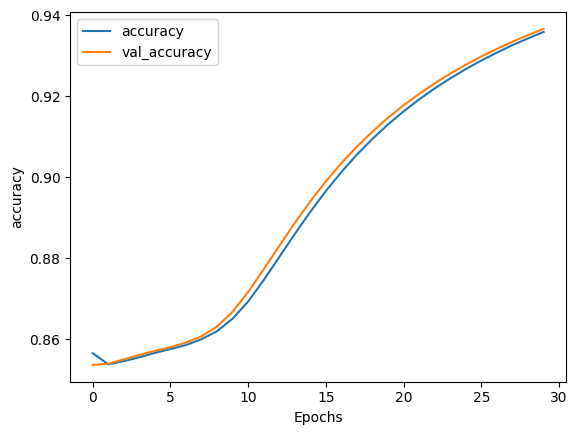

In [15]:
plot_graphs(history, 'accuracy')

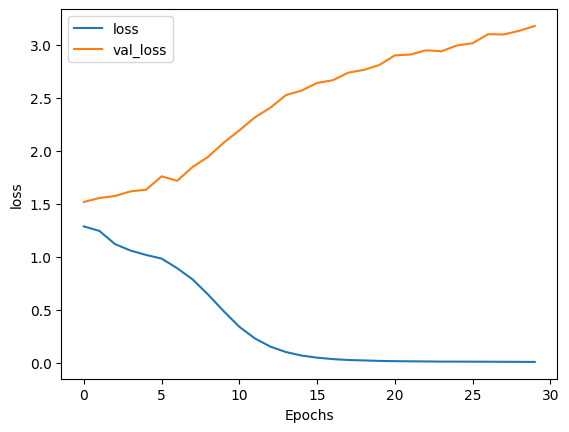

In [16]:
plot_graphs(history, 'loss')

In [17]:
SAVE_FILE_NM = "checkpoints.weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [18]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[ 4682  6397 15689 10494  9640  2706]
평소에 필요했던 게 좋을 것 같아요
